# Algoritmos - Actividad Guiada 3

Nombre: Alfonso Cabrero de Diego<br>
Colab: [https://drive.google.com/file/d/1rc_HVFlNRZgK-bUSla8KpNHQDgpgD_Nr/view?usp=sharing](https://drive.google.com/file/d/1rc_HVFlNRZgK-bUSla8KpNHQDgpgD_Nr/view?usp=sharing)<br>
GitHub: [https://github.com/acabrerod/miar/tree/main/03_miar_optimization_algorithms/exercises/Algoritmos_AG3.ipynb](https://github.com/acabrerod/miar/tree/main/03_miar_optimization_algorithms/exercises/Algoritmos_AG3.ipynb)<br>



# Carga de librerias

In [1]:
!pip install requests    #Hacer llamadas http a paginas de la red
!pip install tsplib95    #Modulo para las instancias del problema del TSP

#Carga de los datos del problema

In [2]:
import urllib.request # Hacer llamadas http a paginas de la red
import tsplib95       # Modulo para las instancias del problema del TSP
import math           # Modulo de funciones matematicas. Se usa para exp
import random         # Para generar valores aleatorios


# http://elib.zib.de/pub/mp-testdata/tsp/tsplib/
# Documentacion:
  # http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf
  # https://tsplib95.readthedocs.io/en/stable/pages/usage.html
  # https://tsplib95.readthedocs.io/en/v0.6.1/modules.html
  # https://pypi.org/project/tsplib95/

# Descargamos el fichero de datos (matriz de distancias)
file = "swiss42.tsp"
urllib.request.urlretrieve("http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/swiss42.tsp.gz", file + '.gz')
!gzip -d swiss42.tsp.gz     # Descomprimir el fichero de datos

gzip: swiss42.tsp already exists; do you wish to overwrite (y or n)? n
	not overwritten


## Carga de datos y generación de objeto problem

In [3]:
problem = tsplib95.load(file)

# Nodos
nodos = list(problem.get_nodes())

# Aristas
aristas = list(problem.get_edges())

print(nodos)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]



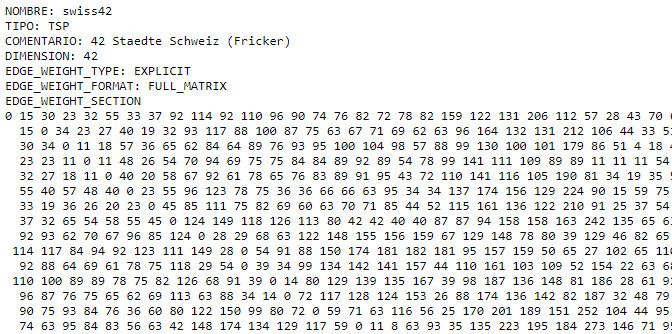

## Probamos algunas funciones del objeto problem

In [4]:
print(f"Distancias entre nodos 0 y 1: {problem.get_weight(0, 1)}")
print(f"Full Matrix: {problem.is_full_matrix()}")

Distancias entre nodos 0 y 1: 15
Full Matrix: True


# Funciones basicas


In [5]:
# Genera una solución aleatoria que empieza en el nodo 0
def crear_solucion(nodos: list) -> list:
  solucion = [ nodos[0] ]
  for n in nodos[1:]:
    siguiente = random.choice(list(set(nodos) - { nodos[0] } - set(solucion)))
    solucion.append(siguiente)
  return solucion

# Devuelve la distancia entre dos nodos
def calcular_distancia(a, b, problem) -> int:
  return problem.get_weight(a,b)

# Devuelve la distancia total de una trayectoria/solucion
def calcular_distancia_total(solucion, problem):
  return sum([
      calcular_distancia(solucion[i], solucion[i + 1], problem)
      for i in range(len(solucion) - 1)
  ]) + calcular_distancia(solucion[-1], solucion[0], problem)



solucion_aleatoria = crear_solucion(nodos)
d = calcular_distancia_total(solucion_aleatoria, problem)

print(f"Solución aleatoria: {solucion_aleatoria}")
print(f"Distancia total asociada: {d}")

Solución aleatoria: [0, 37, 5, 15, 21, 11, 6, 39, 4, 35, 26, 12, 31, 29, 33, 28, 41, 1, 40, 27, 2, 23, 8, 19, 14, 36, 30, 25, 17, 7, 34, 16, 38, 13, 22, 32, 9, 10, 20, 18, 3, 24]
Distancia total asociada: 5188


# Búsqueda de una solución aleatoria

In [6]:
def busqueda_aleatoria(problem, iteraciones_maximas: int) -> list:
  nodos = list(problem.get_nodes())

  mejor_solucion = None
  mejor_distancia = float('inf')

  for _ in range(iteraciones_maximas):
    solucion = crear_solucion(nodos)
    distancia = calcular_distancia_total(solucion, problem)

    # Guarda una nueva solución si es mejor
    if distancia < mejor_distancia:
      mejor_solucion = solucion
      mejor_distancia = distancia

  return mejor_solucion


iteraciones_maximas = 10_000
solucion = busqueda_aleatoria(problem, iteraciones_maximas)
d = calcular_distancia_total(solucion, problem)
print(f"Mejor solución con búsqueda aleatoria en {iteraciones_maximas} iteraciones: {solucion_aleatoria}")
print(f"Distancia total asociada: {d}")

Mejor solución con búsqueda aleatoria en 10000 iteraciones: [0, 37, 5, 15, 21, 11, 6, 39, 4, 35, 26, 12, 31, 29, 33, 28, 41, 1, 40, 27, 2, 23, 8, 19, 14, 36, 30, 25, 17, 7, 34, 16, 38, 13, 22, 32, 9, 10, 20, 18, 3, 24]
Distancia total asociada: 3653


# Búsqueda local por 2-intercambios

In [7]:
import copy
def busqueda_2_intercambios(solucion: list) -> list:
  """
  Devuelve la mejor solución vecina con el criterio de búsqueda local 2-opt
  """

  mejor_solucion = None
  mejor_distancia = float('inf')

  # Generamos todos los posibles 2-intercambios
  for i in range(1, len(solucion) - 1):
    for j in range(i + 1, len(solucion)):
      # Intercambiamos los nodos i <-> j

      vecina = copy.deepcopy(solucion)
      vecina[i], vecina[j] = vecina[j], vecina[i]
      distancia_vecina = calcular_distancia_total(vecina, problem)

      # Nos quedamos con la mejor de todas
      if distancia_vecina < mejor_distancia:
        mejor_solucion = vecina
        mejor_distancia = distancia_vecina

  return mejor_solucion


iteraciones_maximas = 100
solucion_inicial = busqueda_aleatoria(problem, iteraciones_maximas)
d = calcular_distancia_total(solucion_inicial, problem)
print(f"Solución inicial: {solucion_inicial}")
print(f"Distancia total: {d}")


solucion_busqueda_local = busqueda_2_intercambios(solucion_inicial)
d2 = calcular_distancia_total(solucion_busqueda_local, problem)
print(f"\nSolución mejorada tras una iteración de 2-intercambios: {solucion_busqueda_local}")
print(f"Distancia total: {d2}")
print(f"Mejora: {d - d2}")

Solución inicial: [0, 38, 39, 10, 31, 15, 19, 4, 2, 30, 35, 29, 23, 18, 17, 32, 3, 14, 16, 7, 37, 36, 26, 11, 28, 40, 20, 34, 13, 27, 22, 21, 33, 12, 8, 25, 24, 9, 5, 6, 41, 1]
Distancia total: 4019

Solución mejorada tras una iteración de 2-intercambios: [0, 38, 39, 10, 31, 15, 19, 4, 2, 30, 35, 29, 23, 18, 17, 32, 3, 14, 16, 7, 37, 36, 26, 11, 28, 33, 20, 34, 13, 27, 22, 21, 40, 12, 8, 25, 24, 9, 5, 6, 41, 1]
Distancia total: 3591
Mejora: 428


In [8]:
def busqueda_local_iterada(problem) -> tuple[list, int]:
  # Generar una solucion inicial de referencia (aleatoria)
  mejor_solucion = crear_solucion(nodos)
  mejor_distancia = calcular_distancia_total(mejor_solucion, problem)

  iteraciones = 0
  while True:
    iteraciones += 1
    vecina = busqueda_2_intercambios(mejor_solucion)
    distancia_vecina = calcular_distancia_total(vecina, problem)

    # Si no mejoramos hay que terminar. Hemos llegado a
    #    un minimo local (según nuestro operador de vencindad 2-opt)
    if distancia_vecina < mejor_distancia:
      mejor_solucion = vecina
      mejor_distancia = distancia_vecina
    else:
      return mejor_solucion, iteraciones


solucion, iteraciones = busqueda_local_iterada(problem)
d = calcular_distancia_total(solucion, problem)
print(f"Mejor solución con búsqueda local en {iteraciones:_} iteraciones: {solucion}")
print(f"Distancia total asociada: {d}")

Mejor solución con búsqueda local en 44 iteraciones: [0, 3, 1, 37, 15, 16, 14, 19, 13, 18, 27, 34, 33, 20, 35, 36, 8, 10, 25, 11, 12, 7, 17, 31, 32, 28, 30, 29, 39, 21, 24, 40, 23, 41, 9, 22, 38, 2, 4, 26, 5, 6]
Distancia total asociada: 1889


# SIMULATED ANNEALING


In [9]:
def genera_vecino_aleatorio(solucion):
  i, j = sorted(random.sample(range(1, len(solucion)), 2))
  # Intercambio
  vecina = copy.deepcopy(solucion)
  vecina[i], vecina[j] = vecina[j], vecina[i]
  return vecina


# Funcion de probabilidad para aceptar peores soluciones
def probabilidad(t, d):
  if d < 0:
    return True
  return random.random() < math.exp(-d / t)

# Funcion de descenso de temperatura
def bajar_temperatura(t):
  return t * 0.999

In [10]:
def recocido_simulado(problem, temperatura_inicial) -> tuple[list, int]:
  solucion_actual = mejor_solucion = crear_solucion(nodos)
  distancia_actual = mejor_distancia = calcular_distancia_total(solucion_actual, problem)

  temperatura = temperatura_inicial
  iteraciones = 0

  trayectoria = []

  while temperatura > 1e-6:
    iteraciones += 1
    vecino_aleatorio = genera_vecino_aleatorio(solucion_actual)
    distancia_vecina = calcular_distancia_total(vecino_aleatorio, problem)

    # Actualizamos la solucion actual
    if probabilidad(temperatura, distancia_vecina - distancia_actual):
      solucion_actual = vecino_aleatorio
      distancia_actual = distancia_vecina

      # La guardamos si es la mejor solucion
      if distancia_vecina < mejor_distancia:
        mejor_solucion = vecino_aleatorio
        mejor_distancia = distancia_vecina

    # print(f"Mejor: {mejor_distancia}, Actual: {distancia_actual}, Probada {distancia_vecina}")
    trayectoria.append(distancia_actual)

    # bajamos la temperatura
    temperatura = bajar_temperatura(temperatura)
  return mejor_solucion, iteraciones, trayectoria


temperatura_inicial = 1e3

solucion, iteraciones, trayectoria = recocido_simulado(problem, temperatura_inicial)
d = calcular_distancia_total(solucion, problem)
print(f"Mejor solución con simulated annealing con T = {temperatura_inicial:_}, con {iteraciones:_} iteraciones")
print(f"Solucion = {solucion}")
print(f"Mejor distancia: {d}")

Mejor solución con simulated annealing con T = 1_000.0, con 20_713 iteraciones
Solucion = [0, 6, 26, 18, 12, 11, 25, 10, 40, 24, 21, 39, 9, 23, 41, 8, 29, 34, 33, 35, 36, 7, 3, 27, 28, 22, 38, 30, 2, 4, 5, 13, 19, 14, 16, 15, 37, 17, 31, 20, 32, 1]
Mejor distancia: 1680


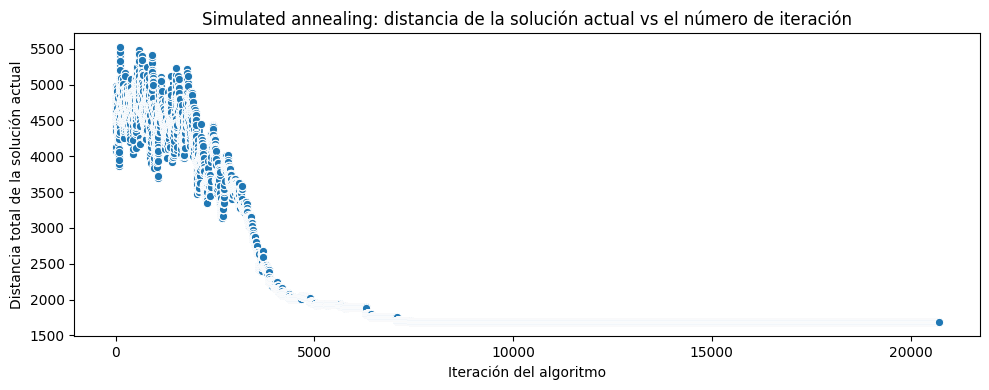

In [11]:
# Gráfico de la distancia vs iteración de simulated annealing
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({ 'Iteración': range(len(trayectoria)), 'Distancia': trayectoria })
plt.figure(figsize = (10, 4))
sns.lineplot(data = df, x = 'Iteración', y = 'Distancia', marker = 'o')

# Títulos
plt.title("Simulated annealing: distancia de la solución actual vs el número de iteración")
plt.xlabel("Iteración del algoritmo")
plt.ylabel("Distancia total de la solución actual")
plt.tight_layout()
plt.show()